In [31]:
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow import keras
from tensorflow.keras import layers, Input, Model, Sequential
from keras.models import load_model
from tensorflow.keras.utils import image_dataset_from_directory

from keras.callbacks import ModelCheckpoint
from keras.applications.vgg16 import VGG16, preprocess_input

import os, shutil, pathlib

In [3]:
orig_dir = "/Users/markroberts/Downloads/dogs-vs-cats/train"
new_dir = "/Users/markroberts/Development/Imperial-MSc/UDA/UDA_Assessment_4_02179784_Roberts/cats_vs_dogs"

def make_subnet(subnet_name, start_index, end_index):
    for category in ('cat', 'dog'):
        directory = new_dir + "/" + subnet_name + "/" + category
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=orig_dir + "/" + fname, dst=directory + "/" + fname)


In [4]:
make_subnet('train', start_index=0, end_index=1000)
make_subnet('validation', start_index=1000, end_index=1500)
make_subnet('test', start_index=1500, end_index=2500)

# Model Part Follows - Part 1

In [8]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(180, 180, 3))

2022-12-24 14:35:02.984102: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        pre_processed_images = preprocess_input(images)
        features = conv_base.predict(pre_processed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

In [10]:
train_ds = new_dir + "/train"
test_ds = new_dir + "/test"
validation_ds = new_dir + "/validation"

train_dataset = image_dataset_from_directory(new_dir + "/train",
                                             image_size=(180, 180),
                                             batch_size=32)
validation_dataset = image_dataset_from_directory(new_dir + "/validation",
                                             image_size=(180, 180),
                                             batch_size=32)
test_dataset = image_dataset_from_directory(new_dir + "/test",
                                             image_size=(180, 180),
                                             batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [14]:
train_features, train_labels = get_features_and_labels(train_dataset)
validation_features, validation_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 1s/step


In [19]:
inputs = Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

callbacks = [
    ModelCheckpoint(filepath='feature_extraction_keras',
                    save_best_only=True,
                    monitor='val_loss')
]
history = model.fit(train_features,
                    train_labels,
                    epochs=20,
                    validation_data=(validation_features, validation_labels),
                    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - ETA: 0s - loss: 13.4669 - accuracy: 0.9190

INFO:tensorflow:Assets written to: feature_extraction_keras/assets


INFO:tensorflow:Assets written to: feature_extraction_keras/assets


63/63 [==============================] - 3s 44ms/step - loss: 13.4669 - accuracy: 0.9190 - val_loss: 3.3138 - val_accuracy: 0.9760
Epoch 2/20
63/63 [==============================] - 2s 31ms/step - loss: 1.8914 - accuracy: 0.9800 - val_loss: 3.4224 - val_accuracy: 0.9780
Epoch 3/20
63/63 [==============================] - 2s 31ms/step - loss: 2.3152 - accuracy: 0.9855 - val_loss: 4.3776 - val_accuracy: 0.9750
Epoch 4/20
63/63 [==============================] - 2s 31ms/step - loss: 1.3904 - accuracy: 0.9915 - val_loss: 8.8316 - val_accuracy: 0.9620
Epoch 5/20
63/63 [==============================] - 2s 31ms/step - loss: 1.9485 - accuracy: 0.9890 - val_loss: 5.3131 - val_accuracy: 0.9740
Epoch 6/20
63/63 [==============================] - 2s 33ms/step - loss: 0.6422 - accuracy: 0.9945 - val_loss: 4.3039 - val_accuracy: 0.9770
Epoch 7/20
63/63 [==============================] - 2s 33ms/step - loss: 0.3729 - accuracy: 0.9960 - val_loss: 4.2385 - val_accuracy: 0.9770
Epoch 8/20
63/63 [=====

In [20]:
model.save("./model_20231224_01.h5")

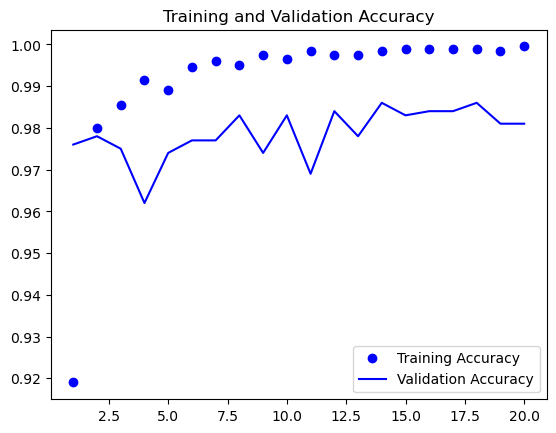

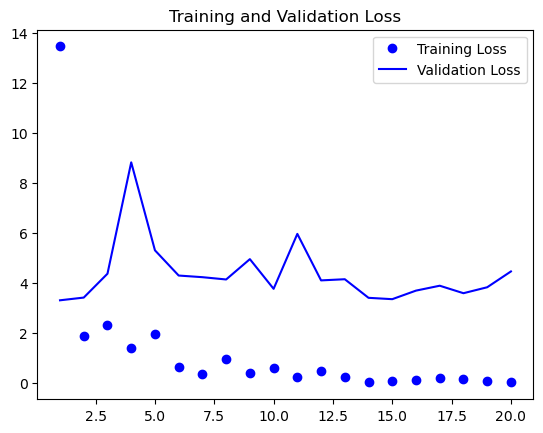

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and Validation Loss')
plt.legend()

# Model Follows - Part 2

In [22]:
conv_base = VGG16(weights='imagenet', include_top=False)

conv_base.trainable = True
print('This is the number of trainable weights before freezong the conv-base', len(conv_base.trainable_weights))

conv_base.trainable = False
print('This is the number of trainable weights before freezong the conv-base', len(conv_base.trainable_weights))

This is the number of trainable weights before freezong the conv-base 26
This is the number of trainable weights before freezong the conv-base 0


In [30]:
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

inputs = Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

callbacks = [
    ModelCheckpoint(filepath='feature_extraction_with_data_augmentation.keras',
                    save_best_only=True,
                    monitor='val_loss')
]
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/50


63/63 [==============================] - 240s 4s/step - loss: 17.0706 - accuracy: 0.8995 - val_loss: 4.9482 - val_accuracy: 0.9620
Epoch 2/50
63/63 [==============================] - 248s 4s/step - loss: 7.0550 - accuracy: 0.9415 - val_loss: 7.8828 - val_accuracy: 0.9590
Epoch 3/50
63/63 [==============================] - 246s 4s/step - loss: 4.0955 - accuracy: 0.9655 - val_loss: 4.9719 - val_accuracy: 0.9670
Epoch 4/50
63/63 [==============================] - 238s 4s/step - loss: 4.3646 - accuracy: 0.9620 - val_loss: 6.1630 - val_accuracy: 0.9640
Epoch 5/50
63/63 [==============================] - 239s 4s/step - loss: 3.4172 - accuracy: 0.9695 - val_loss: 4.5249 - val_accuracy: 0.9690
Epoch 6/50
63/63 [==============================] - 3517s 57s/step - loss: 2.2953 - accuracy: 0.9780 - val_loss: 4.5916 - val_accuracy: 0.9680
Epoch 7/50
63/63 [==============================] - 3279s 53s/step - loss: 1.5904 - accuracy: 0.9795 - val_loss: 6.5145 - val_accuracy: 0.9650
Epoch 8/50
63/63 [=

In [32]:
model.save("./model_20221225_01.h5")

In [37]:
test_model = load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 153s 2s/step - loss: 3.5702 - accuracy: 0.9755
Test accuracy: 0.975
